In [1]:
import tensorflow_hub as hub
import numpy as np
import PIL.Image as img
import tensorflow as tf

In [2]:
EPOCHS = 10
BATCH_SIZE = 32
IMG_SIZE = 224
IMG_CHANNELS = 3

# Creating Train Set

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True,
    rotation_range=10
)

train_gen = train_datagen.flow_from_directory(
    './dataset/train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='sparse'
)

Found 12804 images belonging to 10 classes.


# Creating Test Set

In [4]:
test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True,
    rotation_range=10
)

test_gen = test_datagen.flow_from_directory(
    './dataset/test/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='sparse'
)

Found 1610 images belonging to 10 classes.


# Creating Validation Set

In [5]:
val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True,
    rotation_range=10
)

val_gen = val_datagen.flow_from_directory(
    './dataset/val/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='sparse'
)

Found 1597 images belonging to 10 classes.


# Loading the Pre-trained model

In [6]:
model_pretrained = tf.keras.Sequential([
    hub.KerasLayer(r"https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-classification/versions/4", input_shape=(IMG_SIZE, IMG_SIZE)+(3,))
])

In [8]:
with open('ImageNetLabels.txt', 'r') as f:
    labels = f.read().splitlines()
labels[:10]

['background',
 'tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen']

In [9]:
len(labels)

1001

## Checking the pretrained model with a random image

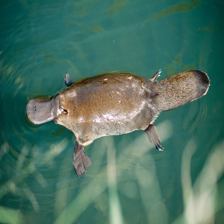

In [11]:
platypus = img.open("Platypus.jpeg").resize((IMG_SIZE, IMG_SIZE))
platypus

In [12]:
platypus_np = np.array(platypus)/255.0
platypus_np.shape

(224, 224, 3)

In [14]:
pred_platypus = model_pretrained.predict(platypus_np[np.newaxis, ...])
pred_platypus

1/1 [==============================] - 3s 3s/step


array([[ 0.20613348,  6.278898  ,  2.5665796 , ...,  1.417501  ,
        -1.5454911 , -0.49734992]], dtype=float32)

In [15]:
labels[np.argmax(pred_platypus)]

'platypus'

# Preparing pre-trained model for new task

In [16]:
feature_extractor_model = r"https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-feature-vector/versions/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False
)

In [21]:
num_of_classes = 10

tr_model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(num_of_classes, activation='softmax')
])

In [22]:
tr_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
tr_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
history = tr_model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    batch_size=BATCH_SIZE,
    steps_per_epoch=int(12804/32),
    validation_steps=int(1597/32),
    verbose=1
)

Epoch 1/10
400/400 [==============================] - 115s 284ms/step - loss: 0.7450 - accuracy: 0.7730 - val_loss: 0.4449 - val_accuracy: 0.8635
Epoch 2/10
400/400 [==============================] - 113s 282ms/step - loss: 0.3919 - accuracy: 0.8779 - val_loss: 0.3765 - val_accuracy: 0.8807
Epoch 3/10
400/400 [==============================] - 113s 281ms/step - loss: 0.3196 - accuracy: 0.8988 - val_loss: 0.2975 - val_accuracy: 0.9133
Epoch 4/10
400/400 [==============================] - 116s 289ms/step - loss: 0.2775 - accuracy: 0.9121 - val_loss: 0.2781 - val_accuracy: 0.9120
Epoch 5/10
400/400 [==============================] - 115s 288ms/step - loss: 0.2519 - accuracy: 0.9206 - val_loss: 0.2721 - val_accuracy: 0.9145
Epoch 6/10
400/400 [==============================] - 115s 287ms/step - loss: 0.2332 - accuracy: 0.9252 - val_loss: 0.2519 - val_accuracy: 0.9126
Epoch 7/10
400/400 [==============================] - 113s 282ms/step - loss: 0.2175 - accuracy: 0.9310 - val_loss: 0.2493 -

In [25]:
tr_model.save("transfered_model.h5")

In [26]:
scores = tr_model.evaluate(test_gen)
scores

51/51 [==============================] - 15s 286ms/step - loss: 0.2123 - accuracy: 0.9298


[0.21232400834560394, 0.9298136830329895]

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

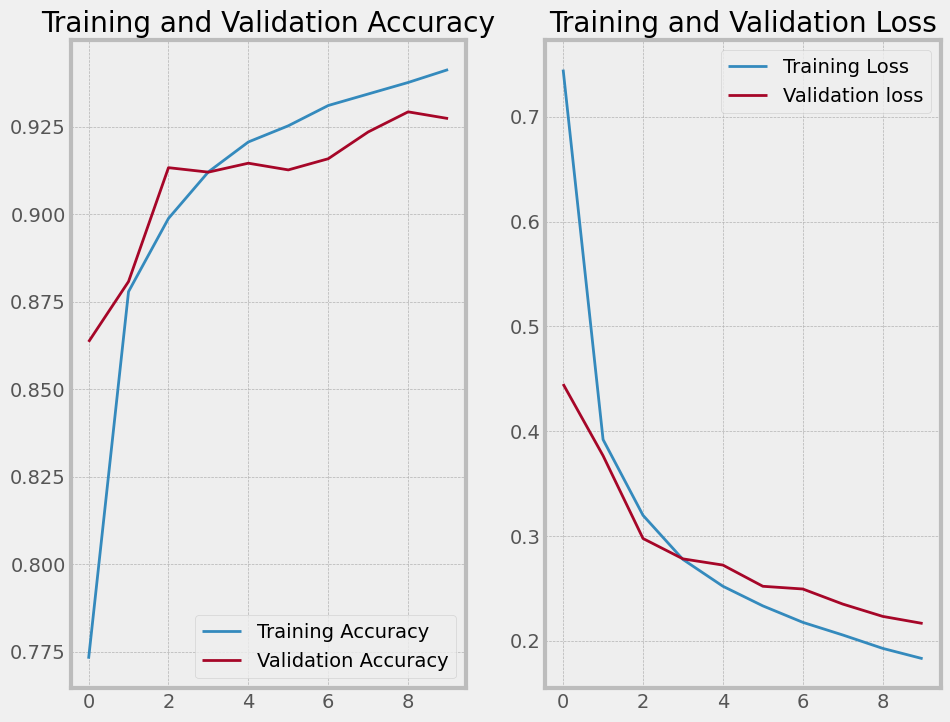

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.style.use('bmh')

plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS),val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')

plt.show()

In [29]:
class_names = list(train_gen.class_indices.keys())

def predict(model, img):
    
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 27ms/step


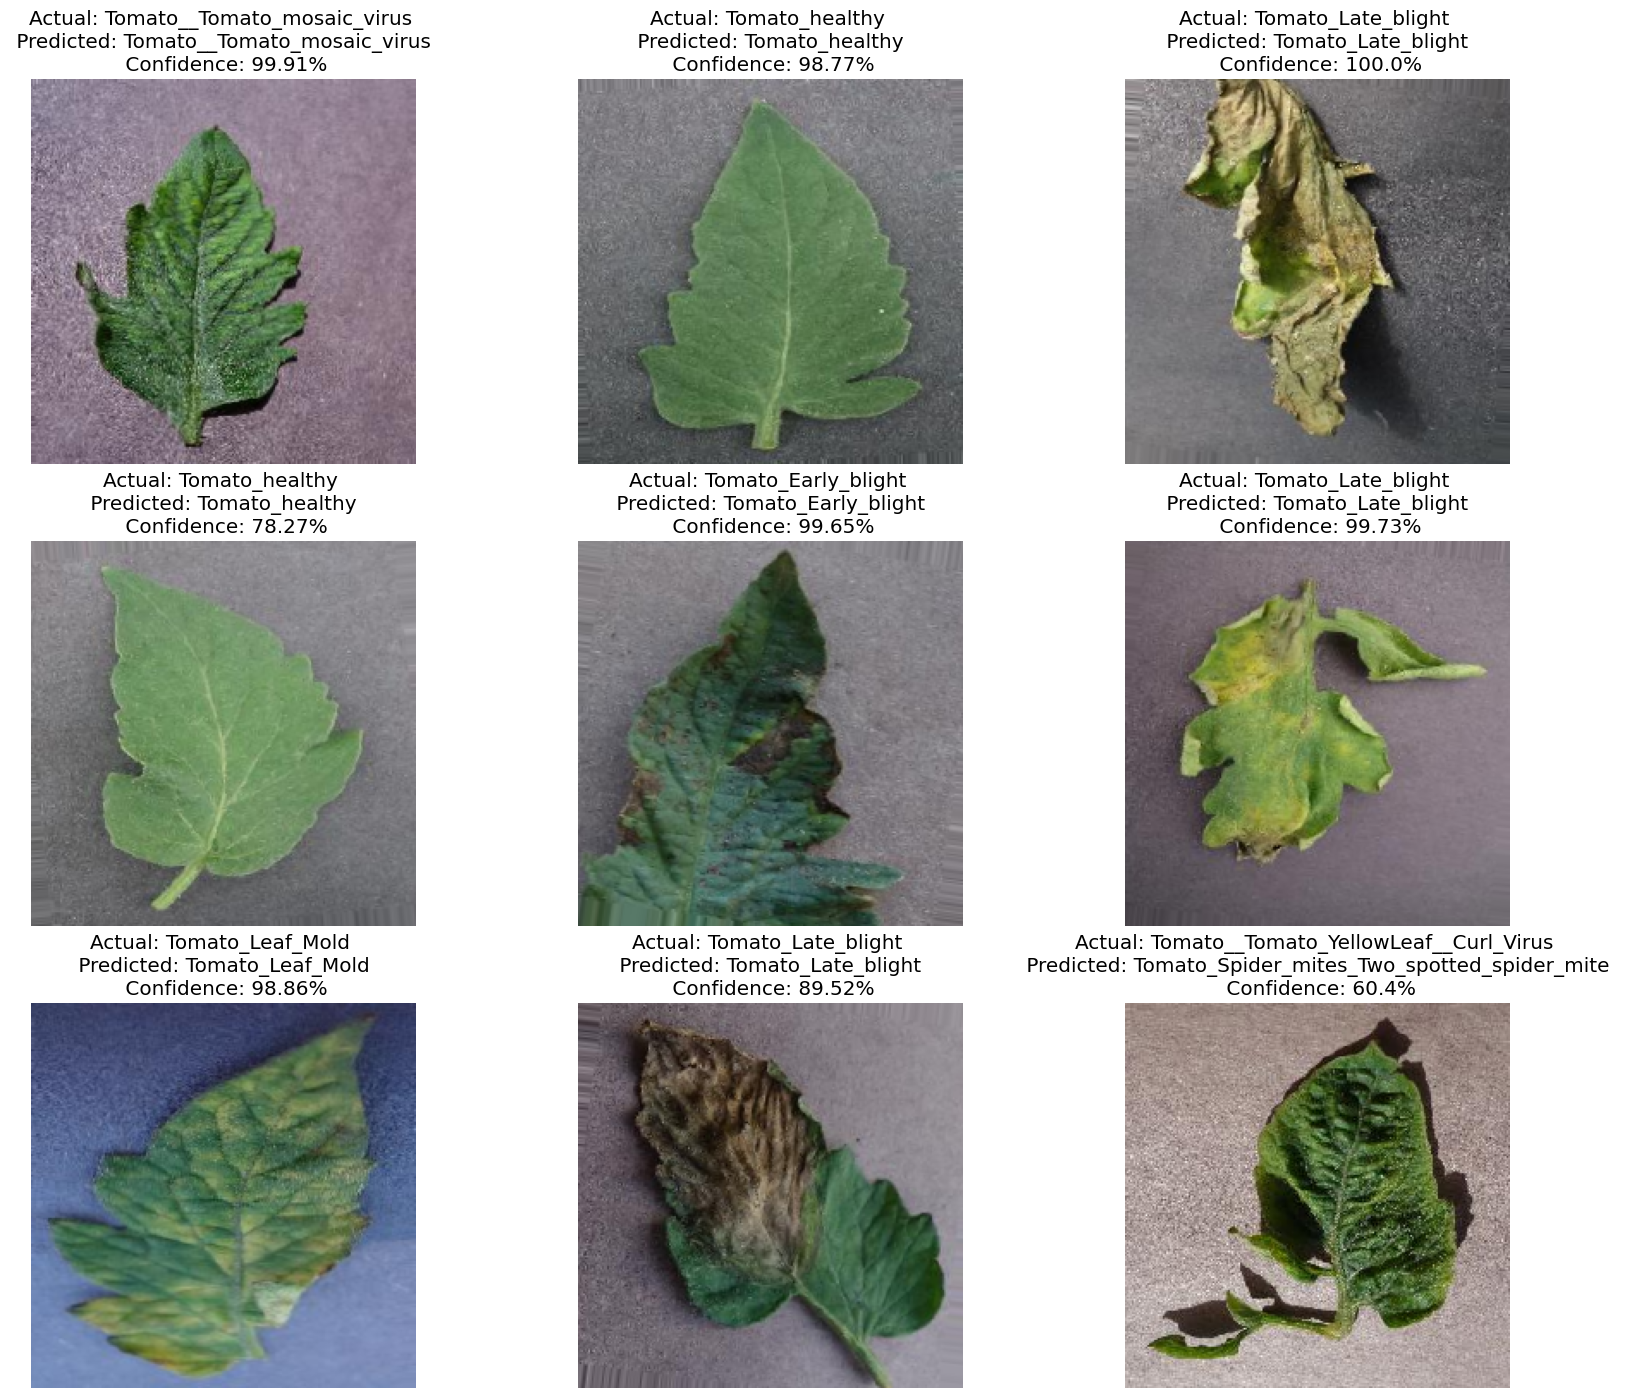

In [32]:
plt.figure(figsize=(20,17))

for images, labels in test_gen:
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i])
        
        pred_class , conf = predict(tr_model, images[i])
        real_class = class_names[int(labels[i])]
        #print(conf)
        
        plt.title(f"Actual: {real_class} \n Predicted: {pred_class} \n Confidence: {conf}%")
        plt.axis("off")
    break